<a href="https://colab.research.google.com/github/andrewunruh1/FBCProj_2/blob/main/project_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
#!pip install --upgrade scikit-learn
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
#!pip install permetrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV)
from matplotlib import pyplot as plt
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

%matplotlib inline

In [ ]:
btc_csv1 = Path('/content/btcNewsToPrice.csv')
btc_csv2 = Path('/content/btcNewsToPrice2.csv')

In [ ]:
btc_1 = pd.read_csv(btc_csv1)
btc_2 = pd.read_csv(btc_csv2)

In [ ]:
btc_1['Merged_tweets_0'] = btc_1[btc_1.columns[1:19]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

btc_2['Merged_tweets_1'] = btc_2[btc_2.columns[1:36]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)


In [ ]:
btc_1_revised = btc_1[['date', 'Merged_tweets_0', 'open', 'high', 'low']]
btc_2_revised = btc_2[['date', 'Merged_tweets_1', 'open', 'high', 'low', 'vol.', 'change %']]

In [ ]:
btc_1_revised.head()

date                                    Merged_tweets_0  ...   high    low
0  2015-07-01  Australia Plays Centralized Role in Banning Mo...  ...  265.0  254.4
1  2015-07-02  Digital Technology to Exponentially Disrupt Bu...  ...  261.3  253.1
2  2015-07-03         How Will Credit Work in a Bitcoin Economy?  ...  256.7  252.4
3  2015-07-04  Improper Network Block Validation Leads to Adv...  ...  261.1  253.4
4  2015-07-05  Bitcoin Documentaries Are Oudated, Time to Tak...  ...  274.1  257.6

[5 rows x 5 columns]

In [ ]:
btc_2_revised.tail()

date  ... change %
2141  2021-05-30  ...    3.09%
2142  2021-05-31  ...    4.62%
2143  2021-06-01  ...   -1.64%
2144  2021-06-02  ...    2.37%
2145  2021-06-03  ...    2.17%

[5 rows x 7 columns]

In [ ]:
consol_df = pd.merge(btc_1_revised, btc_2_revised, how = 'inner', left_on = 'date', right_on = 'date')
consol_df.head()

date  ... change %
0  2015-07-12  ...    6.33%
1  2015-07-13  ...   -6.47%
2  2015-07-14  ...   -1.17%
3  2015-07-15  ...   -1.23%
4  2015-07-16  ...   -2.41%

[5 rows x 11 columns]

In [ ]:
consol_df_rev = consol_df[['date', 'Merged_tweets_0', 'Merged_tweets_1', 'open_y', 'high_y', 'low_y', 'vol.', 'change %']].copy()
consol_df_rev.head()

date  ... change %
0  2015-07-12  ...    6.33%
1  2015-07-13  ...   -6.47%
2  2015-07-14  ...   -1.17%
3  2015-07-15  ...   -1.23%
4  2015-07-16  ...   -2.41%

[5 rows x 8 columns]

In [ ]:
consol_df_rev['Merged_tweets_final'] = consol_df_rev['Merged_tweets_0'].str.cat(consol_df_rev['Merged_tweets_1'],sep=", ")

In [ ]:
df = consol_df_rev[['date', 'Merged_tweets_final', 'open_y', 'high_y', 'low_y', 'vol.', 'change %']]
df.head()

date  ... change %
0  2015-07-12  ...    6.33%
1  2015-07-13  ...   -6.47%
2  2015-07-14  ...   -1.17%
3  2015-07-15  ...   -1.23%
4  2015-07-16  ...   -2.41%

[5 rows x 7 columns]

In [ ]:
# Bitcoin tweets sentiment scores dataframe
sentiments = []

for Merged_tweets_final in df["Merged_tweets_final"]:
    try:
        text = Merged_tweets_final
        results = analyzer.polarity_scores(text)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        sentiments.append({
            "text": text,
            "Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu,
        })
    except AttributeError:
        pass
    
btc_tweets_sentiment  = pd.DataFrame(sentiments)
btc_tweets_sentiment.head(20)

text  ...  Neutral
0   BitGive Foundation Announces New Initiatives a...  ...    1.000
1   The Blockchain: Towards Crypto-Sovereignty,Coi...  ...    1.000
2   Bitcoin in Review: Interesting Trends in Q1 of...  ...    0.897
3   Cash-Back VS Bitcoin: Why Bitcoin can be Super...  ...    0.903
4   Bitcoin-based Transparent Marketplaces Can Pre...  ...    0.813
5   Bitcoin for Mom: Advice for Teaching Loved One...  ...    0.772
6   How Bitcoin Stops the Skimmers and Fraudsters,...  ...    0.879
7   Is Bitcoin A Digital Currency or a Virtual Cur...  ...    0.772
8   The Economic Reformation: A New Ninety-Five Th...  ...    0.874
9   Pro's and Con's on Bitcoin Block Pruning,Money...  ...    0.753
10  Police Violence and the Urgency for Bitcoin in...  ...    0.846
11  The 9 Most Visited Websites in the Bitcoin Eco...  ...    0.814
12  The Great Big Block Size Debate,Verification P...  ...    0.629
13  Blockchain Tech and the Wizardry of Sharing Ec...  ...    0.819
14  Hewlett Packard Shows Interest In Bitcoin,Digi...  ...    0.611
15  Apple Pay: Same Old Ball & Chain,GetGEMS Joini...  ...    0.954
16  BitMesh: Offering Internet Connectivity In Exc...  ...    0.972
17  Bitcoin Companies Could Benefit From Hacker's ...  ...    0.721
18  How Cryptocurrency Can Abolish the Fed (Part 1...  ...    0.839
19  How Cryptocurrency Can Abolish the Fed (Part 2...  ...    0.941

[20 rows x 5 columns]

In [ ]:
#descibed bitcoin tweets sentiment 
btc_tweets_sentiment.describe()

Compound     Positive     Negative      Neutral
count  2141.000000  2141.000000  2141.000000  2141.000000
mean      0.255226     0.094214     0.064358     0.841434
std       0.689022     0.056355     0.051408     0.069012
min      -0.992600     0.000000     0.000000     0.342000
25%      -0.421500     0.057000     0.028000     0.804000
50%       0.526700     0.088000     0.057000     0.849000
75%       0.880700     0.123000     0.091000     0.885000
max       0.997500     0.494000     0.658000     1.000000

In [ ]:
df = pd.merge(df, btc_tweets_sentiment, how = 'inner', left_index = True, right_index = True)
df.head()

date  ... Neutral
0  2015-07-12  ...   1.000
1  2015-07-13  ...   1.000
2  2015-07-14  ...   0.897
3  2015-07-15  ...   0.903
4  2015-07-16  ...   0.813

[5 rows x 12 columns]

In [ ]:
df_final = df[['date', 'text', 'Compound', 'open_y', 'vol.']]
df_final.head()

date  ...     vol.
0  2015-07-12  ...  120.70K
1  2015-07-13  ...  146.85K
2  2015-07-14  ...   60.62K
3  2015-07-15  ...   59.58K
4  2015-07-16  ...  121.32K

[5 rows x 5 columns]

In [ ]:
print(f'sum of null: {df_final.isnull().sum()}')

sum of null: date        0
text        0
Compound    0
open_y      0
vol.        0
dtype: int64


# **Machine Learning Models**

# **Using Random Forest Regressor Model**
## *  Taking into account Compound info as the feature

In [ ]:
# Compound selected as feature in the model
useful_features = ['Compound']
X = df_final.loc[:, useful_features]
y = df_final.loc[:, 'open_y']

# Split data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50
)
# Create a dataframe to store the performance of each models
scores = pd.DataFrame()

In [ ]:
# Create Predict and Plot function for ML methods
def try_different_method(method):
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)

    y_test_temp = y_test.reset_index(drop=True)
    order = y_pred.argsort(axis=0)
    y_pred = y_pred[order]
    y_test_temp = y_test_temp[order]

    #     maer = np.mean(abs(y_pred - y_test_temp) / y_test_temp)
    mse = metrics.mean_squared_error(y_test_temp, y_pred)
    r2 = metrics.r2_score(y_test_temp, y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(len(y_pred)),
        y_test_temp,
        "ro",
        markersize=4,
        label="open_y",
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(y_pred)),
        y_pred,
        "bo-",
        markersize=4,
        label="predict price",
        alpha=0.9,
    )

    plt.grid()
    plt.title("MSE: %f" % mse)
    print("mean_squared_error: %f" % mse)
    print("r2: %f" % r2)
    #     print('mean_abs_error_rate: %f' % maer)
    plt.legend()
    return (r2, mse)

### **Method to estimate best parameters for the model**

In [ ]:
# parameters to search over with cross-validation
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(X_train, y_train)

print("Best parameter values: %r\n" % clf.best_params_)

Best parameter values: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 10}



mean_squared_error: 90340817.346858
r2: 0.286885


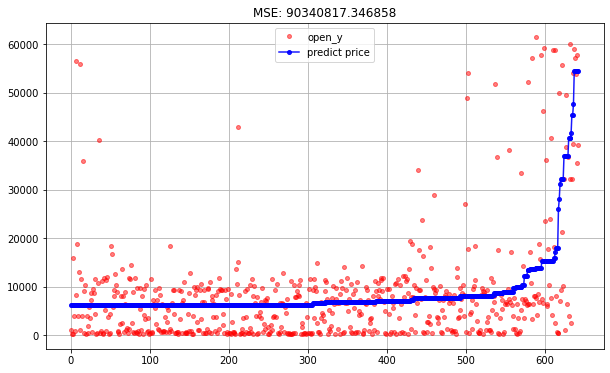

In [ ]:
# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=None,
    
)

performance_rf = try_different_method(rf)

scores.loc[0, "Random Forest"] = performance_rf[0]
scores.loc[1, "Random Forest"] = performance_rf[1]

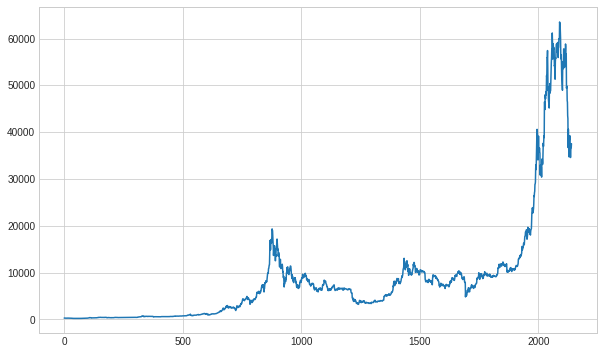

In [ ]:
df_final.open_y.plot(figsize = (10,6))

## **Deep Learning Model using Price as its feature**

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Define the window size
window_size = 20

# Set the index of the feature and target columns
feature_column = 3
target_column = 3

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_final, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:1]} \n")
print (f"y sample values:\n{y[:1]}")

X sample values:
[[292.  310.4 290.4 287.  283.4 276.6 279.6 274.  273.2 277.7 275.1 276.5
  275.5 288.4 288.7 291.8 293.  293.7 283.7 281.4]] 

y sample values:
[[281.6]]


In [ ]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
#print (f"X_train sample values:\n{X_train[:3]} \n")
#print (f"X_test sample values:\n{X_test[:3]}")

In [ ]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
 # Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 20)            1760      
_________________________________________________________________
dropout (Dropout)            (None, 20, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=20, verbose=0)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.00319716171361506

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
close_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
bitcoin = pd.DataFrame({
    "Actual": close_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_final.index[-len(close_prices): ]) 

# Show the DataFrame's head
bitcoin.head()

Actual     Predicted
1504  10566.7  10331.100586
1505  10306.9  10406.578125
1506  10461.6  10489.608398
1507  10402.1  10569.792969
1508  10308.7  10636.549805

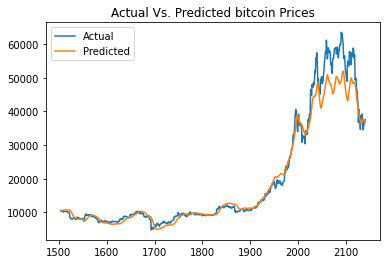

In [ ]:
# Plot the real vs predicted prices as a line chart
bitcoin.plot(title="Actual Vs. Predicted bitcoin Prices")

## **Deep Learning model taking Compound as its feature**

In [ ]:
# Define the window size
window_size = 20

# Set the index of the feature and target columns
feature_column = 2
target_column = 3

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_final, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:1]} \n")
print (f"y sample values:\n{y[:1]}")

X sample values:
[[ 0.      0.      0.      0.      0.4215  0.7964 -0.6369 -0.2263 -0.6369
  -0.8689 -0.8481  0.836   0.4019  0.802   0.9393 -0.1027 -0.1027  0.9081
   0.5859 -0.3612]] 

y sample values:
[[281.6]]


In [ ]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
 # Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 20)            1760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=20, verbose=0)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.08405779302120209

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
close_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
bitcoin_feature = pd.DataFrame({
    "Actual": close_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_final.index[-len(close_prices): ]) 

# Show the DataFrame's head
bitcoin_feature.head()

Actual     Predicted
1504  10566.7  17900.218750
1505  10306.9  17901.867188
1506  10461.6  17902.695312
1507  10402.1  17904.927734
1508  10308.7  17903.931641

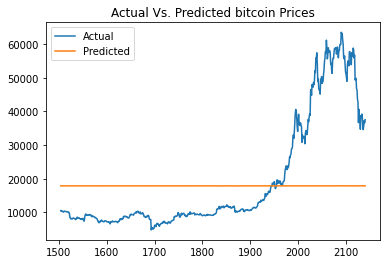

In [ ]:
# Plot the real vs predicted prices as a line chart
bitcoin_feature.plot(title="Actual Vs. Predicted bitcoin Prices")

# **Generating Word Cloud for Bitcoin Tweets**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0] 

In [ ]:
def wordcloud(text, title=""):
    df_cloud = WordCloud(width=500, colormap='RdYlBu').generate(text)
    plt.imshow(df_cloud)
    plt.axis("off")
    fontdict = {"fontsize": 48, "fontweight" : "bold"}
    plt.title(title, fontdict=fontdict)
    plt.show()

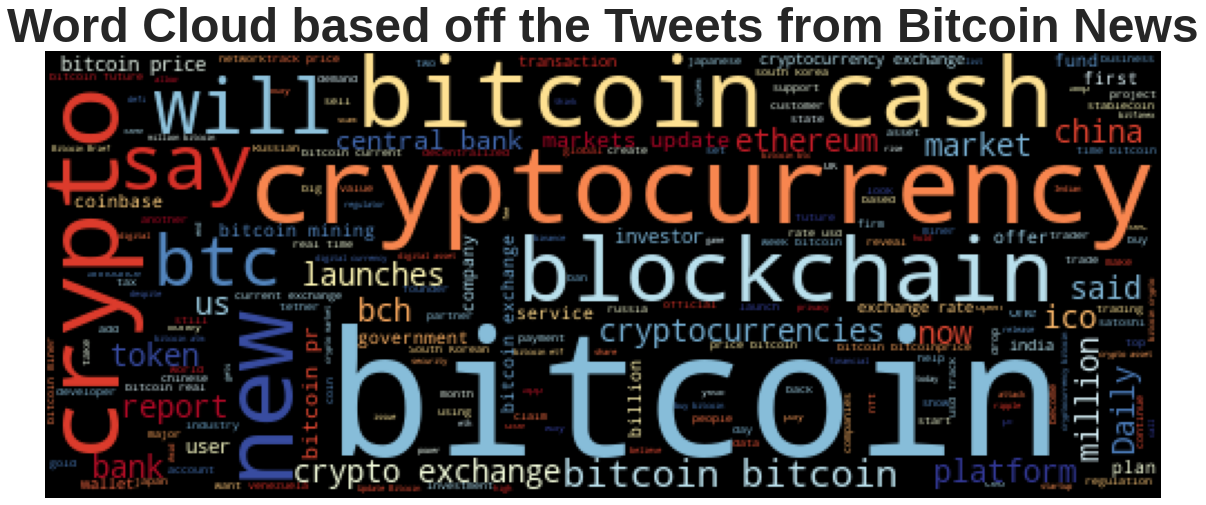

In [ ]:
 wordcloud(df_final.text.str.cat(), title="Word Cloud based off the Tweets from Bitcoin News")

In [ ]:
#creating a df of Bitcoin News Tweets from 2019-2021 because of the max_length capacity of NER proccessing
all_tweets = pd.DataFrame(df_final)
start_date = '2019-01-01'
end_date = '2021-01-01'
mask = (all_tweets['date'] > start_date) & (all_tweets['date'] <= end_date)
  
all_tweets = all_tweets.loc[mask]
display(all_tweets)

date  ...     vol.
1258  2019-01-02  ...  554.47K
1259  2019-01-03  ...  450.32K
1260  2019-01-04  ...  488.70K
1261  2019-01-05  ...  468.45K
1262  2019-01-06  ...  529.89K
...          ...  ...      ...
1983  2020-12-28  ...  126.98K
1984  2020-12-29  ...  119.57K
1985  2020-12-30  ...  159.82K
1986  2020-12-31  ...  136.69K
1987  2021-01-01  ...  100.90K

[730 rows x 5 columns]

In [ ]:
#Concating all the Bitcoin News Tweets text together 
all_tweets = all_tweets.text.str.cat()
all_tweets

'Last Year’s Altcoin Army Have Become This Year’s Bitcoin Brigade,2018\'s Top Cryptocurrencies Ranked by Github Activity,South African Officials Create Regulatory Working Group Dedicated to Cryptocurrencies,Over 900 Retailers Worldwide Now Accept Bitcoin Cash,The Daily: Wallet Brings Bitcoin to Facebook, Fortnite Store Accepts Crypto,Russians See Growing Number of Options to Buy Cryptocurrencies,Hive Criticizes Norwegian Government Amid Concession Cuts to Miners,The Cashaccount.info Platform Tethers Names to Bitcoin Cash Addresses,Japan\'s DMM Exiting Crypto Mining Business, bitcoin cash proponents can now experiment with a new bch powered alias address system called cash accounts   bch     ,over 900 retailers worldwide now accept bitcoin cash    ,the daily  wallet brings bitcoin to facebook  fortnite store accepts crypto    , regarding the current mining machine markets  the environment is increasingly competitive because of the decreased demand mainly due to the decline in the crypto

In [ ]:
# Running the NER processor on all of the text
doc = nlp(all_tweets)

# Adding a title to the document
doc.user_data["title"] = "Bitcoin News Tweets NER"

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
# Listing all Entities in NER proccessed tweet text
x = []
for ent in doc.ents:
    x.append([ent.text, ent.label_])

x[:10]

[['Last Year', 'DATE'],
 ['Altcoin Army', 'ORG'],
 ['This Year', 'DATE'],
 ['Bitcoin', 'GPE'],
 ['Github Activity', 'PERSON'],
 ['South African', 'NORP'],
 ['Cryptocurrencies', 'ORG'],
 ['Wallet Brings Bitcoin', 'LOC'],
 ['Facebook', 'GPE'],
 ['Accepts Crypto', 'PERSON']]

In [ ]:
 # Extract geopolitical, Person entities
entities = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'PERSON']]

In [ ]:
# lower and join each entity for word cloud creation
entities = [i.lower().replace(' ', '_') for i in entities]

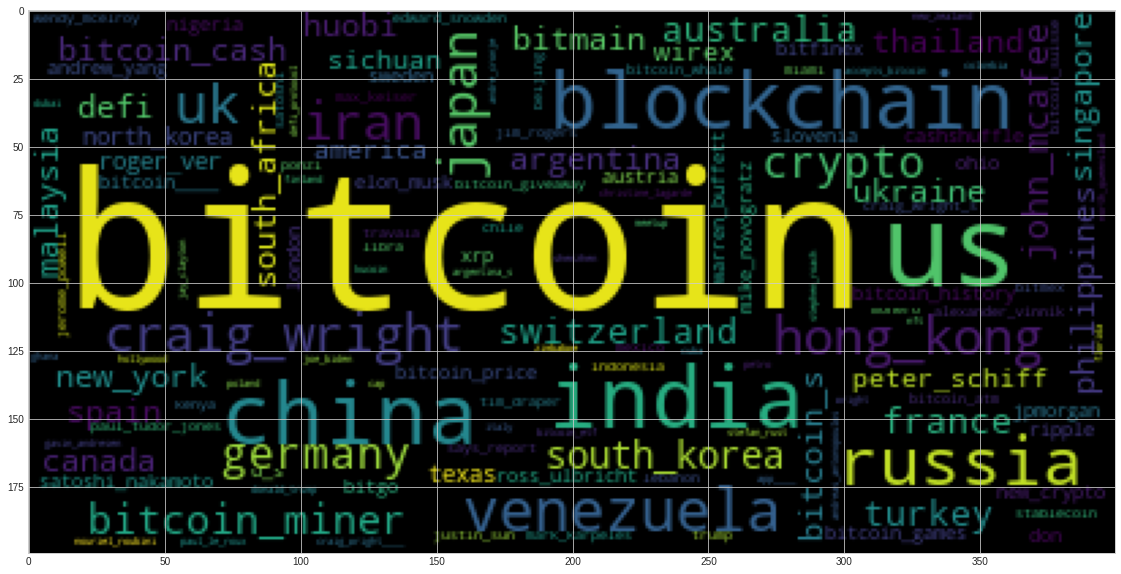

In [ ]:
# Generated wordcloud on Most tweeted about Geopolitical and Person entities
wc = WordCloud().generate(' '.join(entities))
plt.imshow(wc)